In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import datetime as dt
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from Function import *
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook



import warnings
warnings.filterwarnings("ignore")

In [2]:
data1 = pd.read_csv('train.csv',index_col= 0 )
data1['Date'] = pd.to_datetime(data1['Date'])
data1 = data1[['Date','AveragePrice','Value_diff_1','Value_diff_2']]
data1.index = data1['Date']
data1 = data1[['AveragePrice','Value_diff_1','Value_diff_2']]
data1.head()

,AveragePrice,Value_diff_1,Value_diff_2
Date,,,
2015-01-04,1.80,NaN,NaN
2015-01-11,1.92,0.12,NaN
2015-01-18,1.79,-0.13,-0.25
2015-01-25,1.82,0.03,0.16
2015-02-01,1.76,-0.06,-0.09


# Smoothing : plot to have intuitive insight from this time series

In [3]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

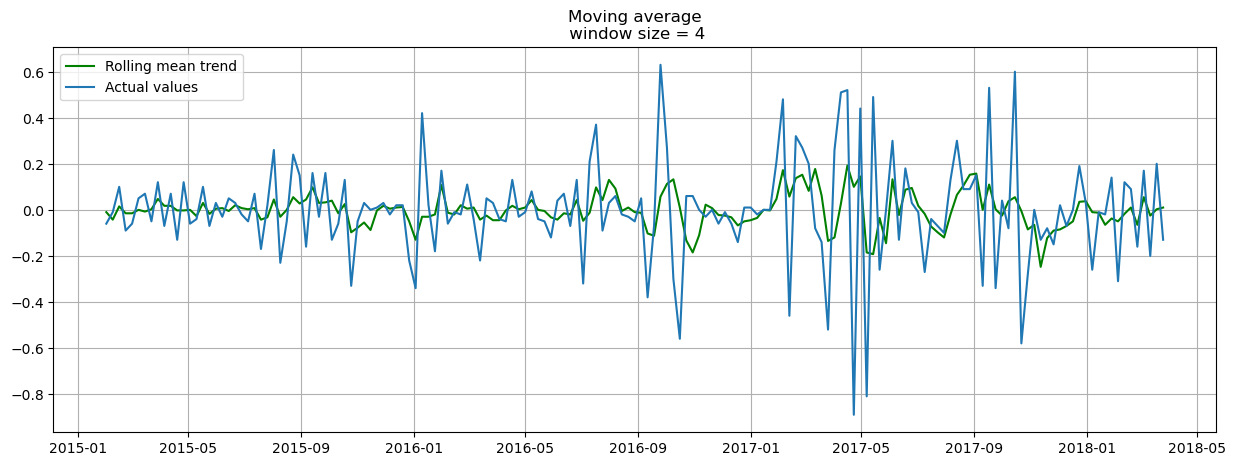

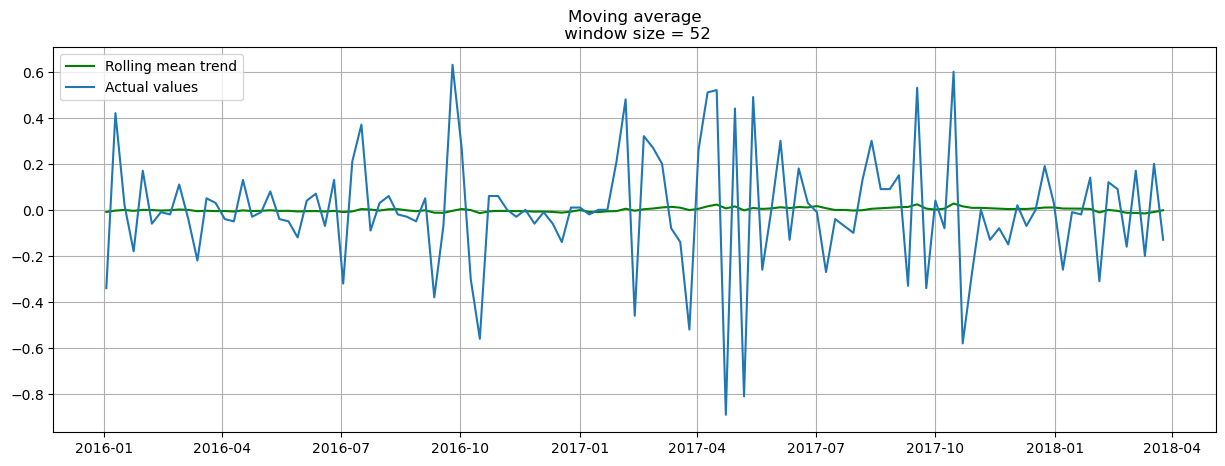

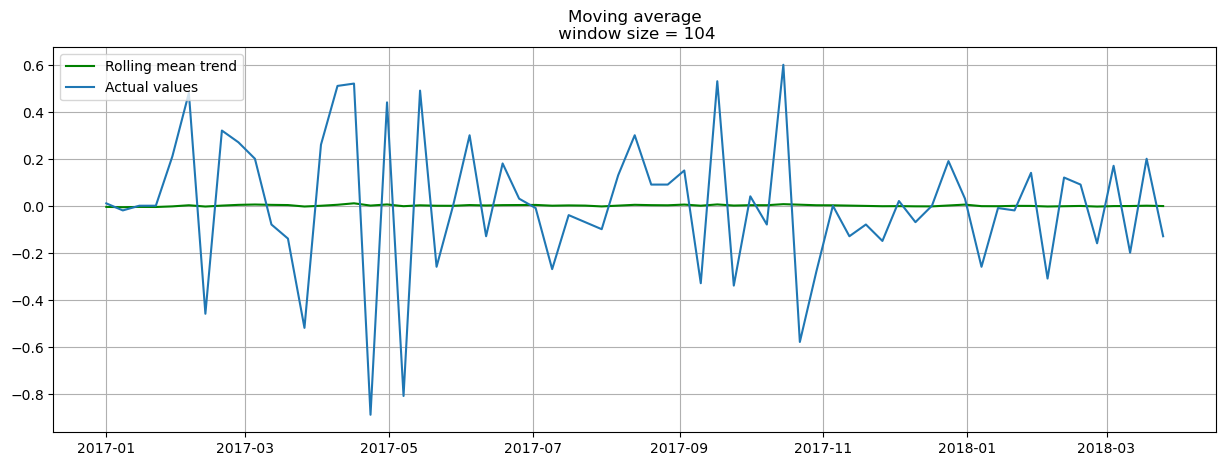

In [4]:
# 
# month
plotMovingAverage(data1['Value_diff_1'], 4)
# year
plotMovingAverage(data1['Value_diff_1'], 52)
# year
plotMovingAverage(data1['Value_diff_1'], 52+52)


# EDA

# Differencing 

In [5]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.7f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

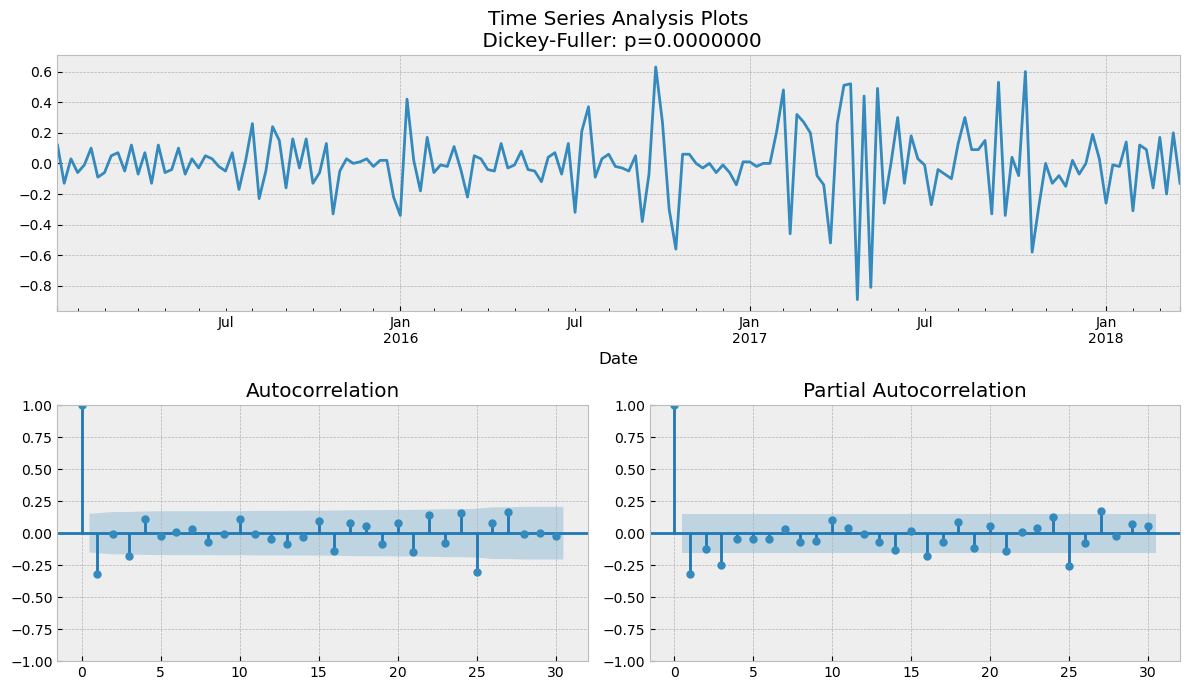

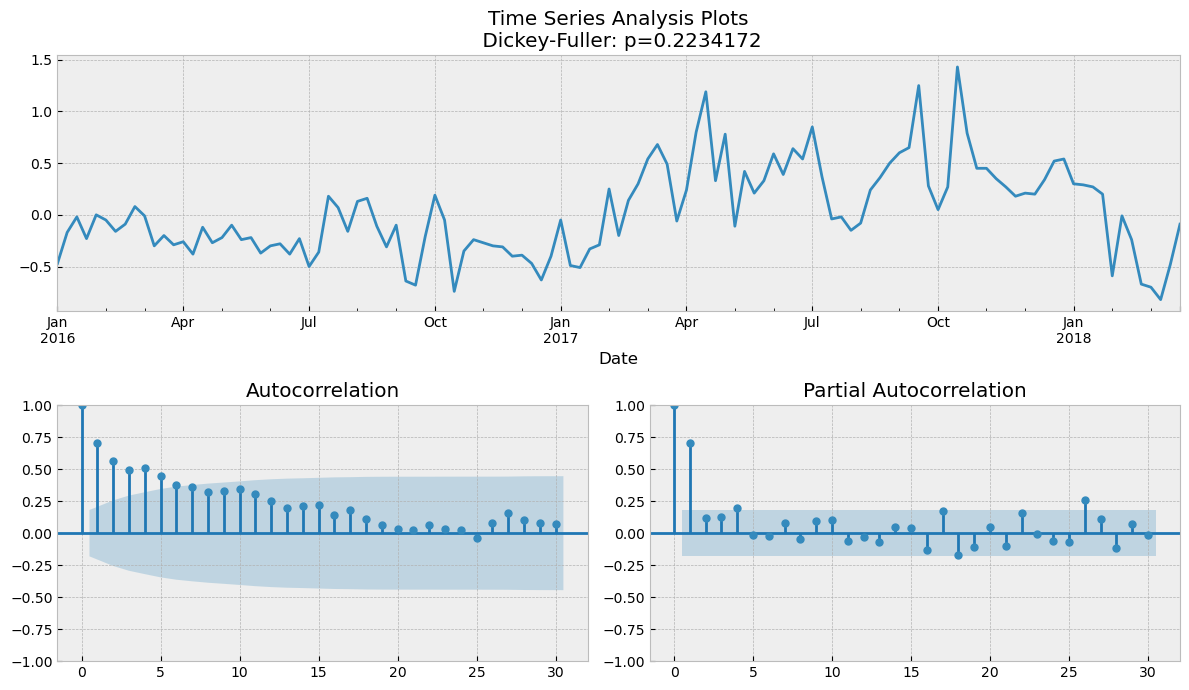

In [6]:
# Diff_1
tsplot(data1['Value_diff_1'][1:], lags=30)

# diff followed by year
diff = data1['AveragePrice'] - data1['AveragePrice'].shift(52)
tsplot(diff[52:], lags=30)

- When decomposing the data, we see the seasonal trend followed by year, and after seasonal differencing, the data is not stationary at all. 

- The plot of residuals still have corr with other lags. 

* P-value is < 0.05 -> Stationary data. So in model we can diff once in order to reach stationary

* Look at the ACF and PCAF plots

Fit SARIMA 
- p = 1
- d = 1
- q = 1
- P = 1
- D = 1
- Q = 5
- S = 52


In [7]:
def optimizeSARIMA(data,parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        data: train_data
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(data, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [8]:
# setting initial values and some bounds for them
p = 1
d=1 
q = 1
P = 1
D= 1
Q = 5
s = 52

# creating list with all the possible combinations of parameters
# parameters = product(ps, qs, Ps, Qs)
# parameters_list = list(parameters)
# result_table = optimizeSARIMA(data1['AveragePrice'],parameters_list, d, D, s)
# # set the parameters that give the lowest AIC
# p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(data1['AveragePrice'][:157], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                            SARIMAX Results                                             
Dep. Variable:                                     AveragePrice   No. Observations:                  157
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2, 3, 4, 5], 52)   Log Likelihood                 -13.832
Date:                                          Fri, 12 Apr 2024   AIC                             45.664
Time:                                                  09:58:59   BIC                             69.463
Sample:                                              01-04-2015   HQIC                            55.306
                                                   - 12-31-2017                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar

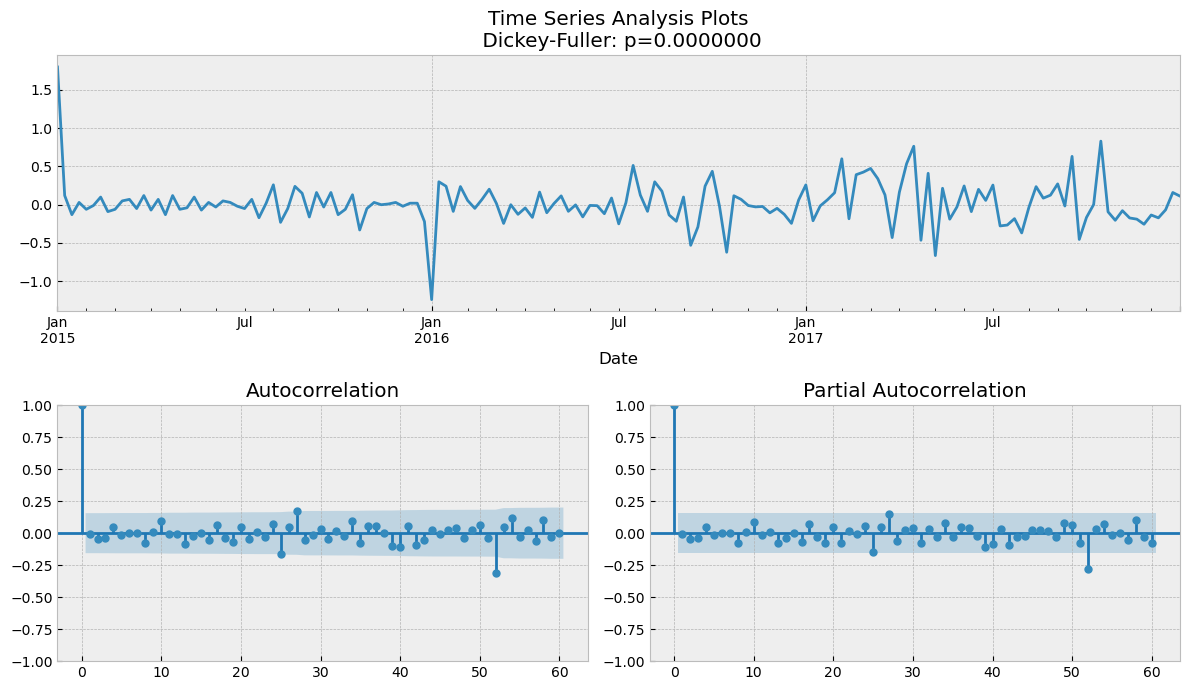

In [11]:
tsplot(best_model.resid, lags=60)

In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / len(y_true))) * 100

def plotSARIMA(series, split ,model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series[:split].copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.nan
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+ n_steps)

    pre_data = pd.concat((series[split:], forecast), axis = 1)
    pre_data.columns = ['actual','arima_model']
    data = pd.concat([data,pre_data], axis = 0)
    # # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(data.arima_model, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)
    return data

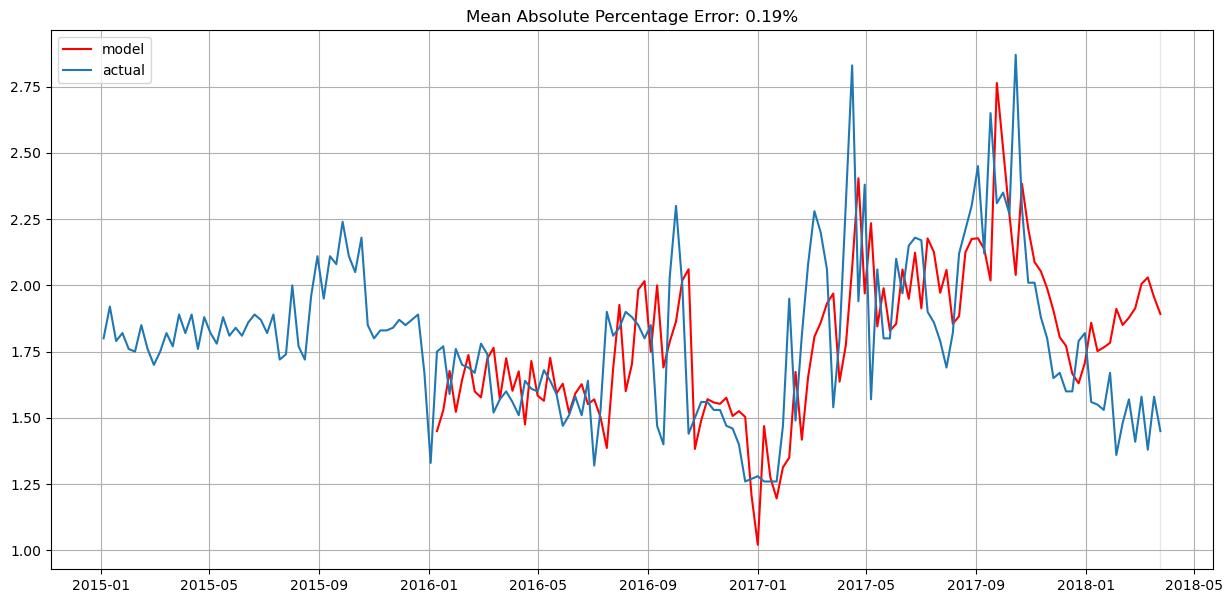

In [17]:
a= plotSARIMA(data1[['AveragePrice']], 157, best_model, 11)


In [ ]:

# # Extracting x and y values
# x = np.arange(len(data1.index)).reshape(-1, 1) 
# y = data1['AveragePrice']

# # Create a linear regression model
# model = LinearRegression()

# # Fit the model
# model.fit(x, y)

# # Predict the y values
# predictions = model.predict(x)

# # Plotting the original data and the linear trend
# plt.figure(figsize=(10, 6))
# plt.plot(data1.index, data1['AveragePrice'], marker='o', linestyle='-', label='Original Data')
# plt.plot(data1.index, predictions, linestyle='--', color='red', label='Linear Trend')

# plt.title('Linear Trend Fit')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()

The Seasonal and Trend decomposition using Loess (STL) is a popular method for decomposition, which uses a combination of local regression (Loess) to extract the trend and seasonality components.